In [7]:
import sys
import torch 
sys.path.append("src")


In [5]:
from torch.utils.data import DataLoader
from dataloader import CollateFunctionSongDetection, SongDetectorDataClass


collate_fn = CollateFunctionSongDetection(segment_length=768)

test_class = SongDetectorDataClass("/home/george-vengrovski/Documents/data/tweety_net_test")
test_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

train_class = SongDetectorDataClass("/home/george-vengrovski/Documents/data/tweety_net_train")
train_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

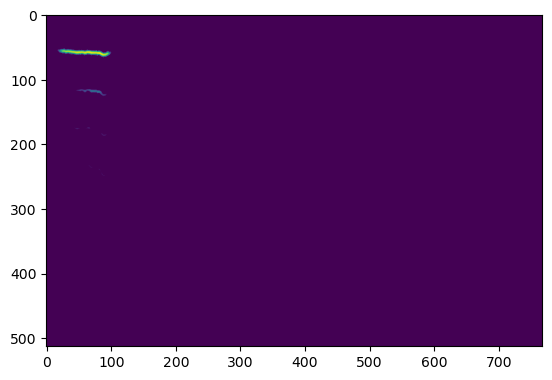

In [6]:
_, s = next(iter(test_loader))
import matplotlib.pyplot as plt

plt.imshow(_[0,0])

In [31]:
from model import TweetyNet


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TweetyNet(hidden_size=384, rnn_dropout=0.2, num_classes=1)
model = model.to(device)

Batch 25: FER = 11.63%, Train Loss = 0.1541, Val Loss = 0.2977
Batch 50: FER = 10.40%, Train Loss = 0.0859, Val Loss = 0.2406
Batch 75: FER = 12.20%, Train Loss = 0.6710, Val Loss = 0.2907
Batch 100: FER = 16.04%, Train Loss = 0.1638, Val Loss = 0.3330
Batch 125: FER = 13.75%, Train Loss = 0.1622, Val Loss = 0.3946
Batch 150: FER = 9.38%, Train Loss = 0.2219, Val Loss = 0.2355
Batch 175: FER = 7.87%, Train Loss = 0.1896, Val Loss = 0.2026
Batch 200: FER = 7.49%, Train Loss = 0.3176, Val Loss = 0.0110
Batch 225: FER = 6.85%, Train Loss = 0.2728, Val Loss = 0.0119
Batch 250: FER = 9.54%, Train Loss = 0.2679, Val Loss = 0.0131
Batch 275: FER = 6.58%, Train Loss = 0.2560, Val Loss = 0.0141
Batch 300: FER = 13.88%, Train Loss = 0.2475, Val Loss = 0.0157
Batch 325: FER = 6.80%, Train Loss = 0.2447, Val Loss = 0.0168
Batch 350: FER = 10.59%, Train Loss = 0.2357, Val Loss = 0.0180
Batch 375: FER = 10.55%, Train Loss = 0.2334, Val Loss = 0.0194
Batch 400: FER = 8.48%, Train Loss = 0.2364, Val L

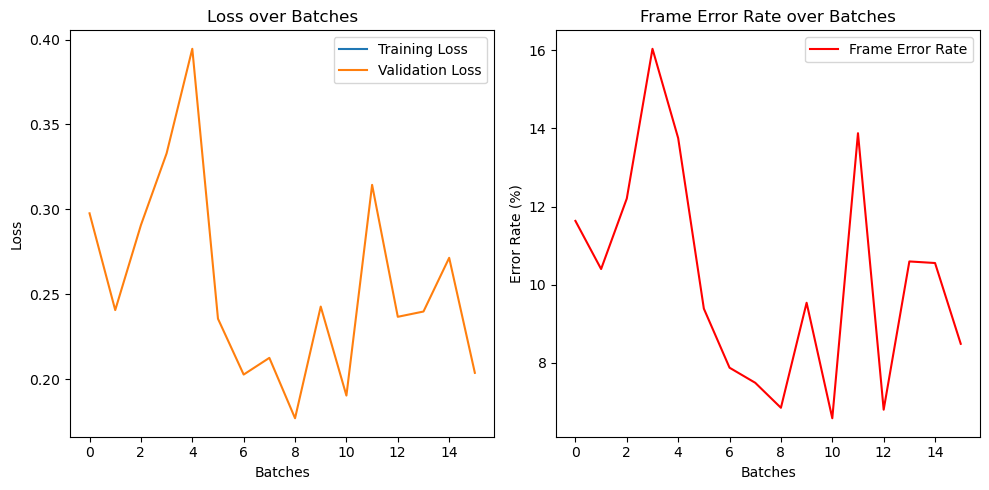

In [32]:
trainer = Trainer(model=model, train_loader=train_loader, test_loader=test_loader, device=device, lr=3e-4, plotting=True, batches_per_eval=25, desired_total_batches=5e3, patience=8)
trainer.train()

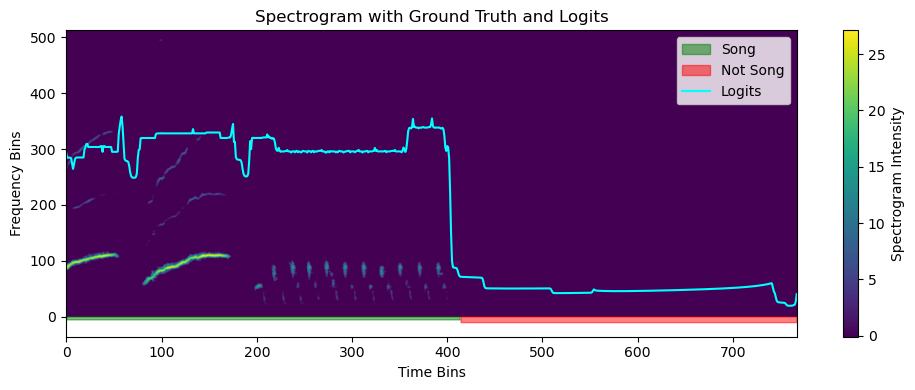

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply sigmoid to logits to scale them between 0 and 1
    logits_sigmoid = sigmoid(logits.squeeze().detach().cpu().numpy())  # Ensure logits is 1D before applying sigmoid

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as bars at the bottom
    times = np.arange(ground_truth_label.shape[0])
    song_bar_height = np.full_like(ground_truth_label.numpy(), -5)  # Slightly below the spectrogram
    not_song_bar_height = np.full_like(ground_truth_label.numpy(), -10)  # Further below for clarity

    plt.fill_between(times, song_bar_height, where=ground_truth_label.numpy() > 0.5, color='green', step='mid', alpha=0.5, label='Song')
    plt.fill_between(times, not_song_bar_height, where=ground_truth_label.numpy() <= 0.5, color='red', step='mid', alpha=0.5, label='Not Song')

    # Overlay logits as a line plot
    plt.plot(times, logits_sigmoid * (spec.shape[0] - 1), color='cyan', label='Logits')  # Scale logits to match spectrogram's frequency range

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming `test_loader`, `model`, and `device` are defined and initialized in your code
spec, ground_truth_label = next(iter(test_loader))  # Get a batch from your DataLoader

logit = model(spec.to(device))  # Get model predictions

# Use the first example in the batch for plotting
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logit = logit[0]  # Adjust based on your model's output shape

# Remove channel dimension if present
if spec.dim() > 2:
    spec = spec.squeeze(0)

# Plot using the function
plot_spectrogram_with_labels_and_logits(spec.cpu(), ground_truth_label.cpu(), logit.cpu())
